In [17]:
import pandas as pd

product_knowledgebase = [
    {"name": "Boho Dress", "desc": "Flowy earthy-toned midi with tassels for outdoor festivals and nature escapes.",
     "tags": ["boho", "nature", "cozy"], "category": "casualwear", "tone": "earthy", "material": "cotton"},
    {"name": "Techwear Jacket", "desc": "Sleek waterproof shell, reflective zippers, modular pockets built for urban movement.",
     "tags": ["urban", "tech", "futuristic"], "category": "outerwear", "tone": "dark", "material": "nylon"},
    {"name": "Cashmere Sweater", "desc": "Luxuriously soft knit in neutral beige, perfect for quiet evenings or premium layering.",
     "tags": ["cozy", "luxury", "classic"], "category": "knitwear", "tone": "neutral", "material": "cashmere"},
    {"name": "Neon Athletic Set", "desc": "Compression-fit neon co-ord that amplifies confidence and energy in workouts.",
     "tags": ["energetic", "sporty", "bold"], "category": "activewear", "tone": "bright", "material": "spandex"},
    {"name": "Vintage Denim", "desc": "Straight-leg faded wash denim with subtle distressing and heritage stitching.",
     "tags": ["classic", "relaxed", "vintage"], "category": "bottomwear", "tone": "lightwash", "material": "denim"},
    {"name": "Business Blazer", "desc": "Structured navy blazer with precision tailoring and power-ready silhouette.",
     "tags": ["formal", "sharp", "professional"], "category": "formalwear", "tone": "navy", "material": "wool"},
    {"name": "Plaid Flannel Shirt", "desc": "Red–black rugged flannel offering warmth, comfort, and casual weekend vibes.",
     "tags": ["cozy", "rugged", "casual"], "category": "casualwear", "tone": "warm", "material": "flannel"},
]

df = pd.DataFrame(product_knowledgebase)
print(" Knowledge base ready with", len(df), "fashion products.")


 Knowledge base ready with 7 fashion products.


In [48]:
import numpy as np
from sentence_transformers import SentenceTransformer

PRIMARY_MODEL = "BAAI/bge-small-en-v1.5"        
FALLBACK_MODEL = "paraphrase-MiniLM-L12-v2"    
_model = None
_loaded_name = None

def _get_model():
    global _model, _loaded_name
    if _model is not None:
        return _model
    try:
        _model = SentenceTransformer(PRIMARY_MODEL)
        _loaded_name = PRIMARY_MODEL
    except Exception as e:
        print(f" Could not load {PRIMARY_MODEL}: {e}\n→ Falling back to {FALLBACK_MODEL}")
        _model = SentenceTransformer(FALLBACK_MODEL)
        _loaded_name = FALLBACK_MODEL
    return _model

def _l2_normalize(x: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(x, axis=1, keepdims=True) + 1e-12
    return (x / n).astype(np.float32)

def embed_texts(texts):
    texts = [t.replace("\n", " ") for t in texts]
    vecs = _get_model().encode(texts, convert_to_numpy=True, normalize_embeddings=False)
    return _l2_normalize(vecs)

df["fusion"] = df.apply(lambda r: f"{r['desc']} tags: " + " ".join(r["tags"]), axis=1)

item_vecs = embed_texts(df["fusion"].tolist())
print(f" Embeddings ready: {item_vecs.shape} (model={_loaded_name})")


 Embeddings ready: (7, 384) (model=BAAI/bge-small-en-v1.5)


In [49]:
from sklearn.metrics.pairwise import cosine_similarity
import time, pandas as pd

def jaccard(a, b):
    sa, sb = set(map(str.lower, a)), set(map(str.lower, b))
    return len(sa & sb) / max(1, len(sa | sb))

def _dyn_vibe_boost(qtokens_len, base=0.15):
    if qtokens_len <= 3: return min(base + 0.05, 0.25)
    if qtokens_len >= 8: return max(base - 0.05, 0.10)
    return base

def rank(query, top_k=3, low_conf_threshold=0.35):
    start = time.perf_counter()
    q_vec = embed_texts([query])
    sims = cosine_similarity(q_vec, item_vecs)[0]
    qtags = [t.strip(",.!?-").lower() for t in query.split() if len(t) > 2]
    vibe_boost = _dyn_vibe_boost(len(qtags))

    rows = []
    for i, row in df.iterrows():
        cos_sim = float(sims[i])
        vibe_sim = float(jaccard(qtags, row["tags"]))
        combined = (1.0 - vibe_boost) * cos_sim + vibe_boost * vibe_sim
        rows.append({
            "name": row["name"],
            "desc": row["desc"],
            "tags": ", ".join(row["tags"]),
            "cosine_sim": round(cos_sim, 4),
            "vibe_overlap": round(vibe_sim, 4),
            "combined_score": round(combined, 4)
        })

    out = pd.DataFrame(rows).sort_values("combined_score", ascending=False).head(top_k).reset_index(drop=True)
    latency_ms = (time.perf_counter() - start) * 1000
    fallback = "No strong matches. Try adding more style details." if out.iloc[0]["combined_score"] < low_conf_threshold else None
    return out, latency_ms, fallback





Query: energetic urban chic
Top-3:
             name                                                                                  desc                    tags  cosine_sim  vibe_overlap  combined_score
  Techwear Jacket Sleek waterproof shell, reflective zippers, modular pockets built for urban movement. urban, tech, futuristic      0.7045           0.2          0.6036
       Boho Dress        Flowy earthy-toned midi with tassels for outdoor festivals and nature escapes.      boho, nature, cozy      0.6858           0.0          0.5486
Neon Athletic Set         Compression-fit neon co-ord that amplifies confidence and energy in workouts. energetic, sporty, bold      0.6259           0.2          0.5408

Query: cozy minimalist neutral
Top-3:
               name                                                                                    desc                  tags  cosine_sim  vibe_overlap  combined_score
   Cashmere Sweater Luxuriously soft knit in neutral beige, perfect for q

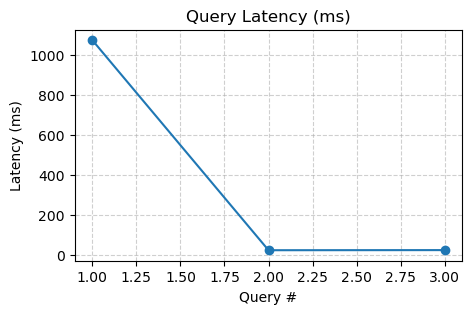

In [ ]:
import pandas as pd, matplotlib.pyplot as plt

queries = ["energetic urban chic", "cozy minimalist neutral", "vintage boho festival"]
records = []

for q in queries:
    top3, t_ms, fb = rank(q, top_k=3)
    best = float(top3.iloc[0]["combined_score"])
    records.append({
        "query": q,
        "top_match": top3.iloc[0]["name"],
        "best_score": best,
        "good@0.6": best >= 0.60,
        "latency_ms": round(t_ms, 2),
        "fallback": fb or ""
    })
    print(f"\nQuery: {q}\nTop-3:")
    print(top3.to_string(index=False))
    if fb: print(" Fallback:", fb)

eval_df = pd.DataFrame(records)
print("\n Evaluation Summary:")
print(eval_df.to_string(index=False))

plt.figure(figsize=(5, 3))
plt.title("Query Latency (ms)")
plt.plot(range(1, len(eval_df) + 1), eval_df["latency_ms"], marker="o")
plt.xlabel("Query #"); plt.ylabel("Latency (ms)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
